In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.interpolate import splprep, splev
from scipy.spatial.transform import Rotation as R

%matplotlib inline

In [2]:
# Load the dataset
file_path = 'tile_data_v2.csv'  # replace with the actual path to your dataset
data = pd.read_csv(file_path)

data.head()

,timestamp,x,y,z,yaw,v_horizontal,v_vertical,accel,steer
0,2048.004209,452197.462912,3.949667e+06,88.468085,-0.390413,0.011836,0.030021,0.0,-38.0
1,2048.104465,452197.467826,3.949667e+06,88.463231,-0.393374,0.038694,-0.091738,0.0,-38.0
2,2048.207218,452197.465972,3.949667e+06,88.469801,-0.385135,0.049873,0.043076,0.0,-38.0
3,2048.304435,452197.465861,3.949667e+06,88.467945,-0.380474,0.034952,-0.009294,0.0,-38.0
4,2048.404340,452197.465777,3.949667e+06,88.468571,-0.386001,0.013054,-0.024935,0.0,-38.0


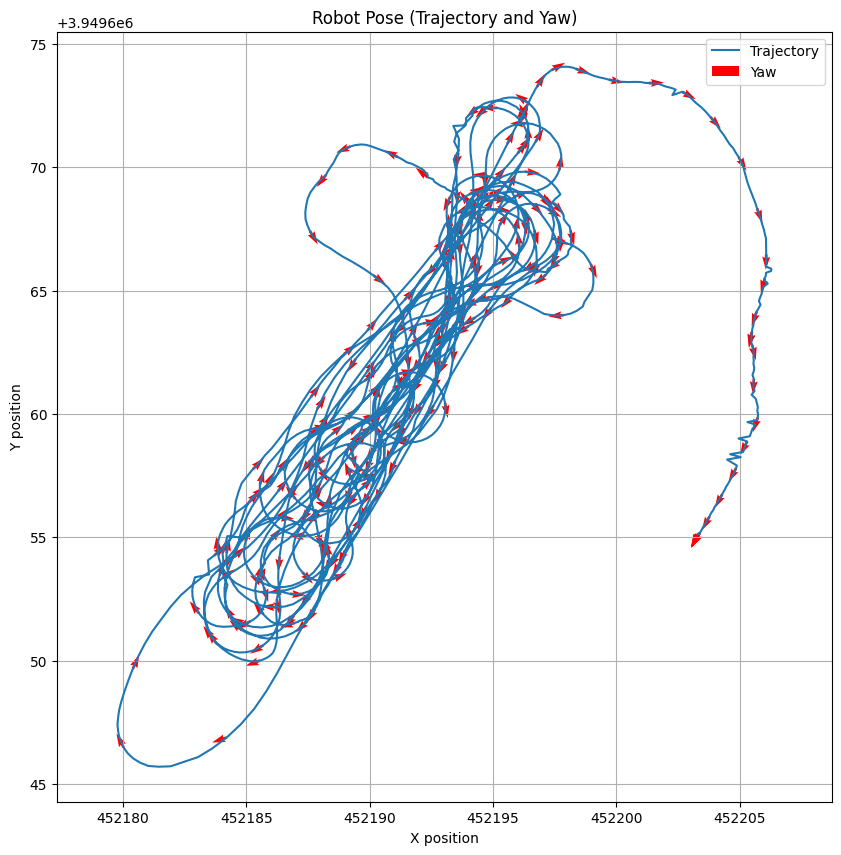

In [3]:
# Extract time, position (x, y), and yaw (orientation)
time = data['timestamp']
x = data['x'].values  # Convert to 1D array
y = data['y'].values  # Convert to 1D array
yaw = data['yaw'].values


# Create a figure for the plot
plt.figure(figsize=(10, 10))

# Plot the robot's trajectory
plt.plot(x, y, label="Trajectory")

# Add quiver plot to show yaw at different points
skip = 10  # Plot yaw every 'skip' points to avoid clutter
plt.quiver(x[::skip], y[::skip], np.cos(yaw[::skip]), np.sin(yaw[::skip]), 
           color='r', scale=50, label="Yaw")

# Add labels and title
plt.xlabel("X position")
plt.ylabel("Y position")
plt.title("Robot Pose (Trajectory and Yaw)")
plt.legend()

# Show the plot
plt.grid(True)
plt.axis('equal')  # Ensure equal scaling for both axes
plt.show()

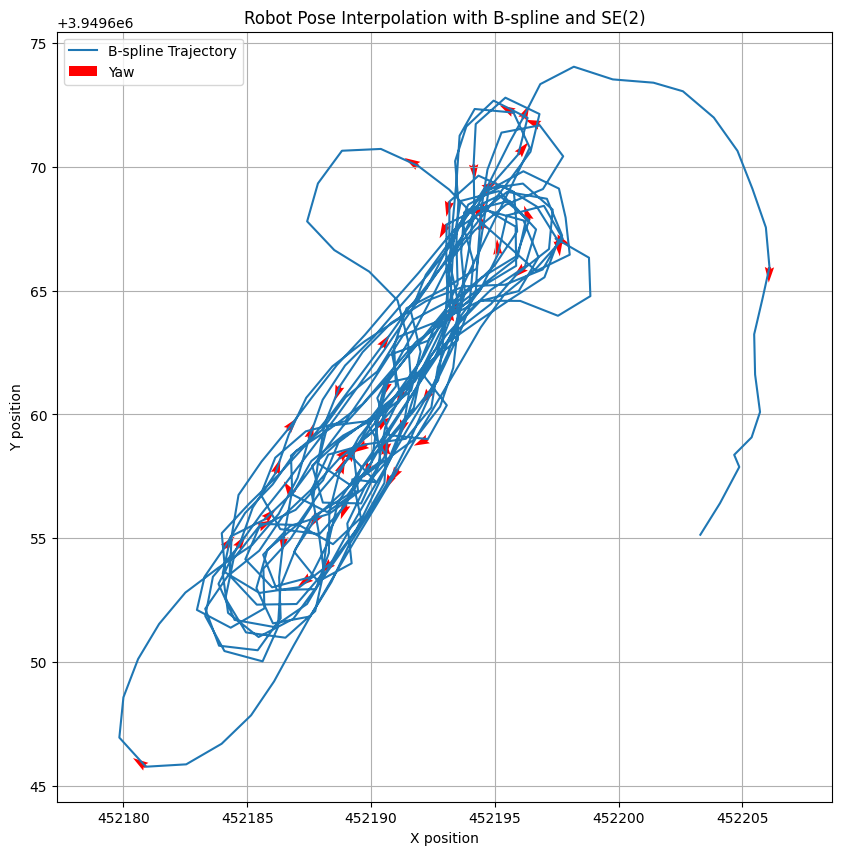

In [7]:
# Remove any NaN or infinite values (if any)
valid_indices = np.isfinite(x) & np.isfinite(y)
x = x[valid_indices]
y = y[valid_indices]
yaw = yaw[valid_indices]

# Filter out consecutive identical points
def remove_consecutive_duplicates(x, y, yaw):
    # Create a mask where consecutive points differ
    diff_mask = (np.diff(x) != 0) | (np.diff(y) != 0)
    # Always keep the first point
    valid_mask = np.concatenate([[True], diff_mask])
    
    return x[valid_mask], y[valid_mask], yaw[valid_mask]

x, y, yaw = remove_consecutive_duplicates(x, y, yaw)

# B-spline interpolation for position (x, y)
try:
    tck, u = splprep([x, y], s=0.001)  # Parametric spline
except Exception as e:
    print(f"Error during B-spline calculation: {e}")
else:
    u_fine = np.linspace(0, 1, 500)  # Fine parameterization
    x_spline, y_spline = splev(u_fine, tck)

    # SE(2) interpolation for yaw
    yaw_spline = np.interp(u_fine, u, yaw)  # Linear interpolation for yaw

    # Convert yaw angles into a rotation matrix (SE(2))
    def yaw_to_rotation_matrix(yaw_angle):
        return np.array([[np.cos(yaw_angle), -np.sin(yaw_angle)], 
                         [np.sin(yaw_angle),  np.cos(yaw_angle)]])

    # Visualize the interpolated trajectory and yaw
    plt.figure(figsize=(10, 10))

    # Plot the interpolated trajectory
    plt.plot(x_spline, y_spline, label="B-spline Trajectory")

    # Plot arrows to visualize the yaw (SE(2) orientation)
    plt.quiver(x_spline[::skip], y_spline[::skip], np.cos(yaw_spline[::skip]), np.sin(yaw_spline[::skip]), 
           color='r', scale=50, label="Yaw")


    # Add labels and title
    plt.xlabel("X position")
    plt.ylabel("Y position")
    plt.title("Robot Pose Interpolation with B-spline and SE(2)")
    plt.legend()

    # Show the plot
    plt.grid(True)
    plt.axis('equal')  # Ensure equal scaling for both axes
    plt.show()